## Downloading the required files

The data collection can be downloaded as Publicly available dataset from Creatis hosting the challange of Automated Cardiac Diagnosis Challenge (ACDC).
The dataset contains a list 100 patients with the main MRI image consist of the training set and 50 pateients with the test set. Data download links can be found in the link below

https://www.creatis.insa-lyon.fr/Challenge/acdc/


Important modules also needed to be installed for oython such as :-
1. Opencv
2. pandas
3. Matplotlib and Seaborn
4. Nibabel and Monai
5. Pytorch
6. Transformers

In [1]:
!pip install nibabel monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.3 MB/s eta 0:00:00


In [2]:
import os
import sys
import random
import time
from copy import deepcopy

import cv2
import numpy as np
import pandas as pd
import nibabel as nib
from monai import data, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import transformers
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
input_size=(224,224,1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_image_path = 'dataset/ACDC/database/training'
test_image_path = 'dataset/ACDC/database/testing'

dict_args = {
    "random_seed": 19,
    "checkpoint": "output_model",
    "predict_mode": False,
    "workers": 4,
    "batch_size": 2,
    "max_epoch": 200,
    "lr": 1e-4,
    "decay": 0.001,
    "lr_factor": 0.5,
    "min_lr": 5e-7,
    "lr_scheduler": "ReduceLROnPlateau"
    }

In [4]:
def read_file_data(directory):
    """
    Read files from directyory to loads images and masks for the ACDC dataset
    Into list of data arrays
    """
    all_imgs = []
    all_gt = []
    all_header = []
    all_affine = []
    info = []
    
    for root, directories, files in os.walk(directory):
        for file in files:
            if ".gz" and "frame" in file:
                if "_gt" not in file:
                    img_path = root + "/" + file
                    img = nib.load(img_path).get_fdata()
                    all_header.append(nib.load(img_path).header)
                    all_affine.append(nib.load(img_path).affine)                   
                    for idx in range(img.shape[2]):
                        i = cv2.resize(img[:,:,idx], (input_size[0], input_size[1]), interpolation=cv2.INTER_NEAREST)
                        all_imgs.append(i)
                        
                else:
                    img_path = root + "/" + file
                    img = nib.load(img_path).get_fdata()
                    for idx in range(img.shape[2]):
                        i = cv2.resize(img[:,:,idx], (input_size[0], input_size[1]), interpolation=cv2.INTER_NEAREST)
                        all_gt.append(i)

    data = [all_imgs, all_gt, info]            
    data[0] = np.expand_dims(data[0], axis=3)
    data[1] = np.expand_dims(data[1], axis=3)
    
    return data

In [5]:
def create_mask(mask_data):
    """
    with the provided masks with many classes, we need to create one mask per class over main scanned MRI image
    """
    masks = np.zeros((mask_data.shape[0], mask_data.shape[1], mask_data.shape[2], 4))
        
    for i in range(mask_data.shape[0]):
        masks[i][:,:,0] = np.where(mask_data[i]==0, 1, 0)[:,:,-1] 
        masks[i][:,:,1] = np.where(mask_data[i]==1, 1, 0)[:,:,-1] 
        masks[i][:,:,2] = np.where(mask_data[i]==2, 1, 0)[:,:,-1] 
        masks[i][:,:,3] = np.where(mask_data[i]==3, 1, 0)[:,:,-1]
    
    return masks

In [6]:
train_data = read_file_data(directory=train_image_path)
train_masks = create_mask(train_data[1])

In [9]:
types_list = []

for index, img in enumerate(train_data[1]):
    img_type = np.unique(img).tolist()
    types_list.append(img_type)
    # end = ","
    # if index%10 ==0:
    #     end = "\n"
    # print(" :: ", np.unique(img).tolist(), end=end)
        
print(types_list)

[[0.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 2.0, 3.0], [0.0, 2.0, 3.0], [0.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0], [0.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0], [0.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 

In [17]:
def create_keys(img_list):
    sorted_list = sorted(img_list)
    str_img_type = [str(x) for x in sorted_list]
    return " ".join(str_img_type)

In [18]:
from collections import Counter

str_types_list = [ create_keys(img_typ) for img_typ in types_list]
ctyp = Counter(str_types_list)
ctyp

Counter({'0.0': 61,
         '0.0 1.0 2.0 3.0': 1543,
         '0.0 2.0 3.0': 265,
         '0.0 1.0': 13,
         '0.0 2.0': 18,
         '0.0 1.0 2.0': 2})

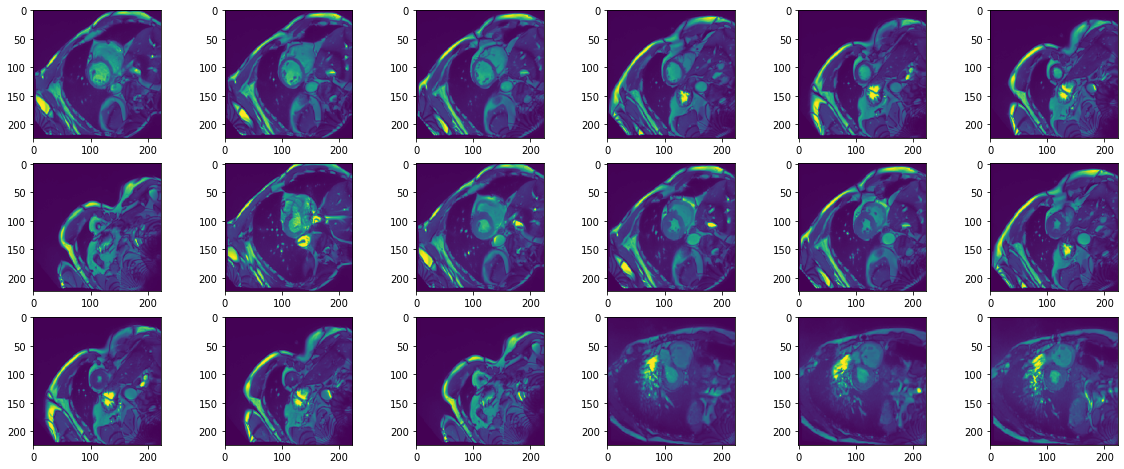

In [7]:
fig = plt.figure(figsize=(20, 8))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    img = train_data[0][i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

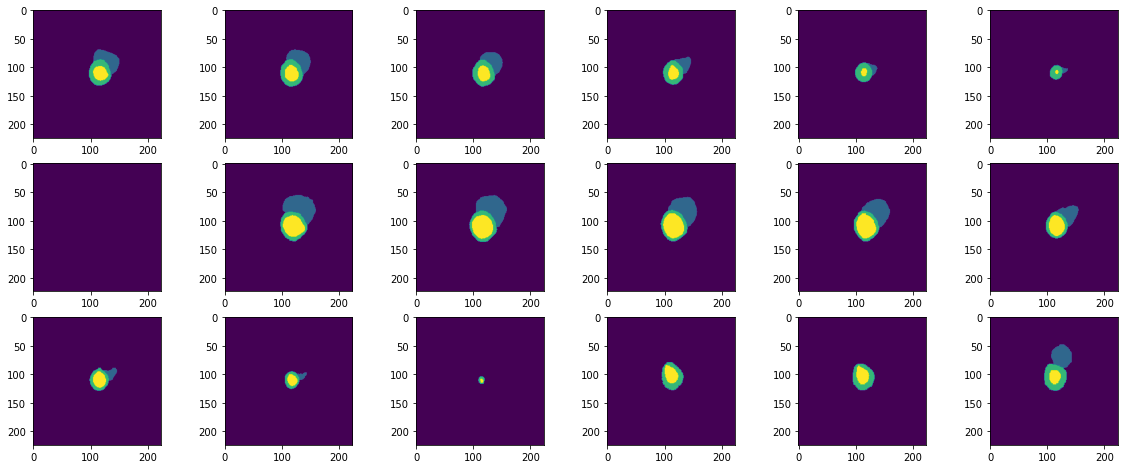

In [19]:
fig = plt.figure(figsize=(20, 8))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    img = train_data[1][i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

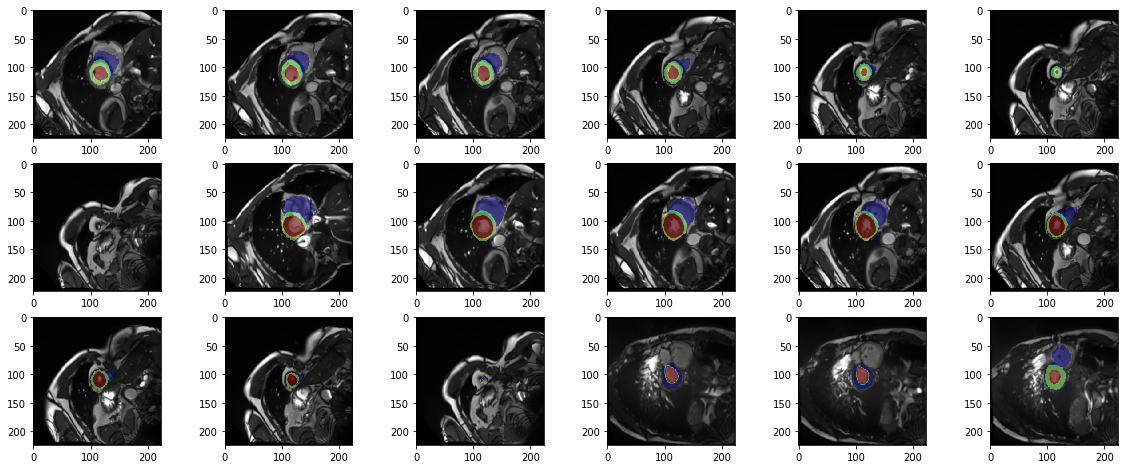

In [9]:
fig = plt.figure(figsize=(20, 8))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    main_img = train_data[0][i]
    mask_img = train_data[1][i]
    masked = np.ma.masked_where(mask_img == 0, mask_img)

    fig.add_subplot(rows, columns, i)
    plt.imshow(main_img, cmap='gray', interpolation=None)
    plt.imshow(masked, cmap='jet', interpolation=None, alpha=0.5)
plt.show()

The maskimage shape is :  (224, 224, 4)


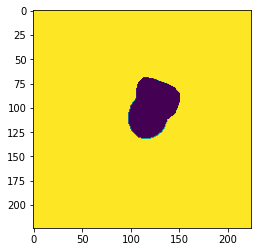

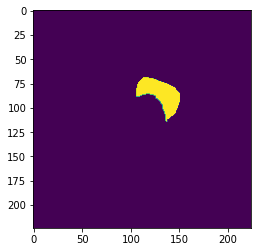

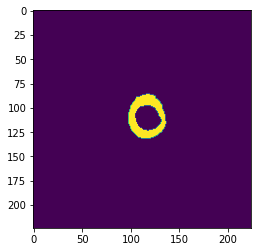

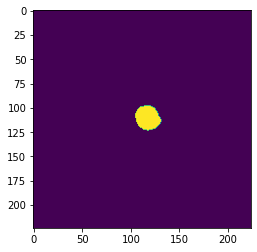

In [23]:
mask_img = train_masks[1]

print("The maskimage shape is : ", mask_img.shape)

plt.imshow(mask_img[:,:, 0])
plt.show()
plt.imshow(mask_img[:,:,1])
plt.show()
plt.imshow(mask_img[:,:,2])
plt.show()
plt.imshow(mask_img[:,:,3])
plt.show()

In [7]:
train_tensor = deepcopy(train_data)

train_tensor[0] = np.transpose(train_tensor[0], (0, 3, 1, 2)) # for the channels
train_tensor[1] = np.transpose(train_masks, (0, 3, 1, 2)) # for the channels
train_tensor[0] = torch.Tensor(train_tensor[0]) # convert to tensors
train_tensor[1] = torch.Tensor(train_tensor[1]) # convert to tensors

# train_tensor[0] =  train_tensor[0].type(torch.float16)
# train_tensor[1] =  train_tensor[1].type(torch.float16)

train_tensor[0].shape

torch.Size([1902, 1, 224, 224])

In [9]:
train_tensor[1].shape

torch.Size([1902, 4, 224, 224])

In [24]:
test_data = read_file_data(directory=test_image_path)
test_masks = create_mask(test_data[1])

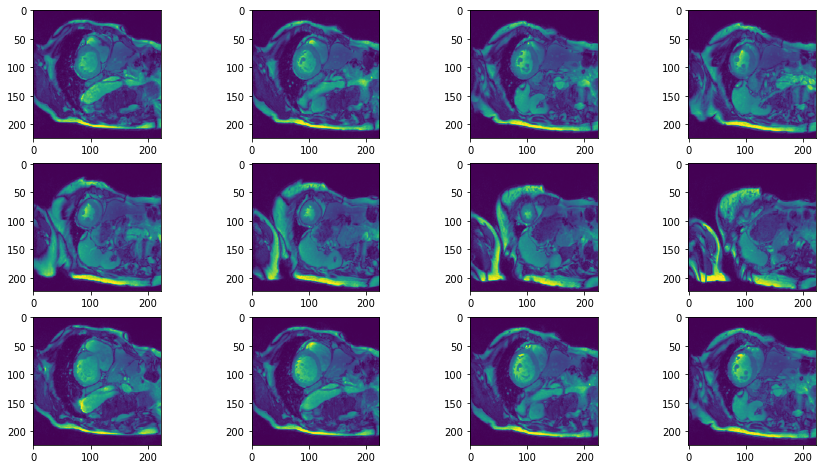

In [13]:
fig = plt.figure(figsize=(15, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = test_data[0][i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

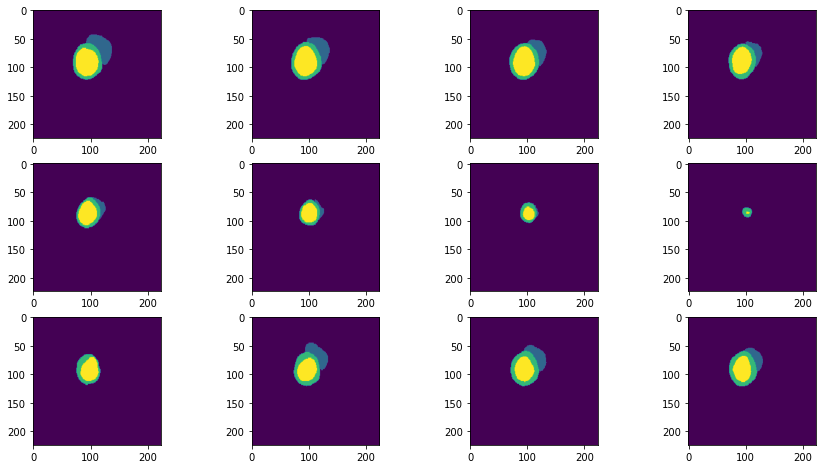

In [14]:
fig = plt.figure(figsize=(15, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = test_data[1][i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

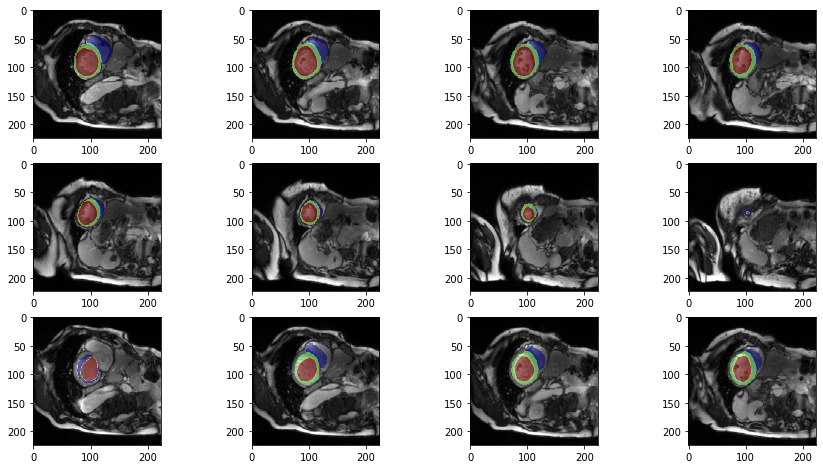

In [15]:
fig = plt.figure(figsize=(15, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    main_img = test_data[0][i]
    mask_img = test_data[1][i]
    masked = np.ma.masked_where(mask_img == 0, mask_img)

    fig.add_subplot(rows, columns, i)
    plt.imshow(main_img, cmap='gray', interpolation=None)
    plt.imshow(masked, cmap='jet', interpolation=None, alpha=0.5)
plt.show()

The mask image test shape is :  (224, 224, 4)


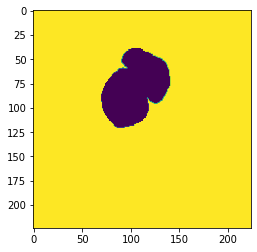

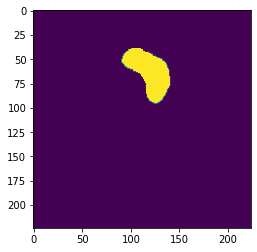

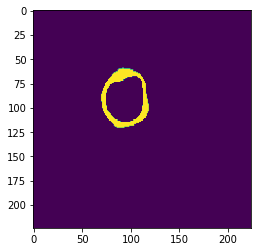

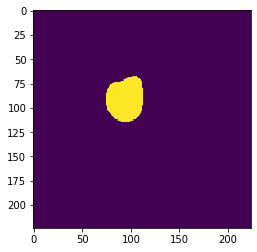

In [25]:
mask_imgt = test_masks[0]

print("The mask image test shape is : ", mask_imgt.shape)

plt.imshow(mask_imgt[:,:, 0])
plt.show()
plt.imshow(mask_imgt[:,:,1])
plt.show()
plt.imshow(mask_imgt[:,:,2])
plt.show()
plt.imshow(mask_imgt[:,:,3])
plt.show()

In [30]:
test_tensor = deepcopy(test_data)

test_tensor[0] = np.transpose(test_tensor[0], (0, 3, 1, 2)) # for the channels
test_tensor[1] = np.transpose(test_masks, (0, 3, 1, 2)) # for the channels
test_tensor[0] = torch.Tensor(test_tensor[0]) # convert to tensors
test_tensor[1] = torch.Tensor(test_tensor[1]) # convert to tensors

# test_tensor[0] =  test_tensor[0].type(torch.float16)
# test_tensor[1] =  test_tensor[1].type(torch.float16)

test_tensor[0].shape

torch.Size([1076, 1, 224, 224])

In [31]:
test_tensor[1].shape

torch.Size([1076, 4, 224, 224])

In [33]:
# training_set = TensorDataset(train_tensor[0], train_tensor[1])
# train_dataloader = DataLoader(training_set, batch_size=dict_args['batch_size'])

testing_set = TensorDataset(test_tensor[0], test_tensor[1])
test_dataloader = DataLoader(testing_set, batch_size=dict_args['batch_size'])

In [12]:
del test_data
del train_data

del test_masks
del train_masks

### Import the model from the model creation python module

In [26]:
from model import FCT

In [27]:
def init_weights(m):
    """
    Initialize the weights
    """
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [28]:
model = FCT(dict_args)
model.apply(init_weights)
model

FCT(
  (scale_img): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (block_1): Block_encoder_bottleneck(
    (layernorm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (trans): Transformer(
      (attention_output): Attention(
        (conv_q): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=8)
        (layernorm_q): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_k): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_k): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_v): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_v): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_

In [15]:
# Starting fresh with no checkpoint available

first_epoch = 0

optimizer = torch.optim.AdamW(model.parameters(), lr=dict_args['lr'], weight_decay=dict_args['decay'])

In [16]:
# Starting from last checkpoint with Resume operation
from datetime import datetime

resume_data = torch.load('output_model/checkpoint.pt')
print(f"Loaded checkpoint saved at {datetime.fromtimestamp(resume_data['time']).strftime('%Y-%m-%d %H:%M:%S')}. "
                  f"Resuming from epoch {resume_data['epoch']}")

model.load_state_dict(resume_data['model'])
optimizer.load_state_dict(resume_data['optimizer'])
for state in optimizer.state.values():
    for k, v in state.items():
        state[k] = v.cuda()

for g in optimizer.param_groups:
    g['lr'] = dict_args['lr']
    g['weight_decay'] = dict_args['decay']

first_epoch = resume_data['epoch'] + 1
print("First epoch on resumed data is : ", first_epoch)

Loaded checkpoint saved at 2023-02-20 14:53:54. Resuming from epoch 160
First epoch on resumed data is :  161


In [29]:
model.load_state_dict(torch.load('output_model/model.pt'))

<All keys matched successfully>

In [18]:
loss_fn = nn.BCELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=dict_args['lr_factor'],
            verbose=True,
            threshold=1e-6,
            patience=10,
            min_lr=dict_args['min_lr'])

model.to(device)

tb_writer = SummaryWriter(log_dir=os.path.join(dict_args['checkpoint'], 'runs'))

In [29]:
optimizer.param_groups[0]['capturable'] = True

In [19]:
max_epoch = dict_args['max_epoch']
min_loss = sys.maxsize

print("The maximim epoch running is : ", max_epoch)

for epoch in range(first_epoch, max_epoch+1):
    model.train()
    # mini batch train
    train_loss_list = []
    grads_dict = {}
    abs_grads_dict = {}
    for index,(X_train,y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        pred_y = model(X_train)
        loss = loss_fn(pred_y[2],y_train)
        train_loss_list.append(loss)
        loss.backward()
        optimizer.step()
        for name, params in model.named_parameters():
            if name not in grads_dict:
                grads_dict[name] = []
                abs_grads_dict[name] = []
            if params.grad is not None:
                grads_dict[name].append(params.grad.mean())
                abs_grads_dict[name].append(params.grad.abs().mean())
    
    optimizer.zero_grad()
    train_loss = torch.tensor(train_loss_list).mean()
    if isinstance(scheduler,torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(train_loss)
    if isinstance(scheduler,torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
        scheduler.step()
    # validate
    model.eval()
    validate_loss_list = []
    with torch.no_grad():
        for i,(X_test,y_test) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            pred_y = model(X_test)
            loss = loss_fn(pred_y[2],y_test)
            validate_loss_list.append(loss)
    validate_loss = torch.tensor(validate_loss_list).mean()
    # tensorboard
    tb_writer.add_scalar('loss/train_loss', train_loss, epoch)
    tb_writer.add_scalar('loss/validate_loss', validate_loss, epoch)
    tb_writer.add_scalar(f'lr/{epoch // 100}', optimizer.param_groups[0]["lr"], epoch)
    for name in grads_dict:
        # 分段看
        tb_writer.add_scalar(f'{name}/{epoch // 100}',torch.tensor(grads_dict[name]).mean(), epoch)
        tb_writer.add_scalar(f'abs_{name}/{epoch // 100}',torch.tensor(abs_grads_dict[name]).mean(), epoch)
    # log
    print('-' * 35)
    print(f'epoch: {epoch},<<  >>train loss:{train_loss:.6f},<<  >>validate loss:{validate_loss:.6f}')
    print('-' * 35)

    # model save
    if validate_loss < min_loss:
        min_loss = validate_loss
        torch.save(model.state_dict(), f"{dict_args['checkpoint']}/model.pt")
        # torch.jit.script(model).save(f'{args.checkpoint}/model/model_jit.pt')
        if dict_args.get('colab'):
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model.pt')
            # torch.jit.script(model).save(f'/content/drive/MyDrive/model_jit.pt')
    
    # checkpoint 
    if epoch % 10 == 0:
        path = "output_model/checkpoint.pt"
        data = {
            'epoch': epoch,
            # Current time (UNIX timestamp)
            'time': time.time(),
            # State dict for all the modules
            'model': model.state_dict(),
            # State dict for all the optimizers
            'optimizer': optimizer.state_dict()
        }

        # Safe replacement of old checkpoint
        temp_file = None
        if os.path.exists(path):
            # There's an old checkpoint. Rename it!
            temp_file = path + '.old'
            os.rename(path, temp_file)

        # Save the new checkpoint
        with open(path, 'wb') as fp:
            torch.save(data, fp)
            # Flush and sync the FS
            fp.flush()
            os.fsync(fp.fileno())

        # Remove the old checkpoint
        if temp_file is not None:
            os.unlink(path + '.old')

The maximim epoch running is :  200


100%|██████████| 538/538 [00:31<00:00, 17.07it/s]


-----------------------------------
epoch: 161,<<  >>train loss:0.091518,<<  >>validate loss:0.091072
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 162,<<  >>train loss:0.091508,<<  >>validate loss:0.091071
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 163,<<  >>train loss:0.091503,<<  >>validate loss:0.091071
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 164,<<  >>train loss:0.091498,<<  >>validate loss:0.091070
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 165,<<  >>train loss:0.091495,<<  >>validate loss:0.091071
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 166,<<  >>train loss:0.091491,<<  >>validate loss:0.091071
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 167,<<  >>train loss:0.091488,<<  >>validate loss:0.091072
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 168,<<  >>train loss:0.091486,<<  >>validate loss:0.091073
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 169,<<  >>train loss:0.091484,<<  >>validate loss:0.091075
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 170,<<  >>train loss:0.091482,<<  >>validate loss:0.091076
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 171,<<  >>train loss:0.091481,<<  >>validate loss:0.091078
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 172,<<  >>train loss:0.091480,<<  >>validate loss:0.091080
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 173,<<  >>train loss:0.091479,<<  >>validate loss:0.091083
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 174,<<  >>train loss:0.091479,<<  >>validate loss:0.091085
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 175,<<  >>train loss:0.091479,<<  >>validate loss:0.091087
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 176,<<  >>train loss:0.091478,<<  >>validate loss:0.091090
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 177,<<  >>train loss:0.091479,<<  >>validate loss:0.091092
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 178,<<  >>train loss:0.091479,<<  >>validate loss:0.091094
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.18it/s]


-----------------------------------
epoch: 179,<<  >>train loss:0.091479,<<  >>validate loss:0.091095
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.15it/s]


-----------------------------------
epoch: 180,<<  >>train loss:0.091479,<<  >>validate loss:0.091096
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.13it/s]


-----------------------------------
epoch: 181,<<  >>train loss:0.091480,<<  >>validate loss:0.091097
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.09it/s]


-----------------------------------
epoch: 182,<<  >>train loss:0.091480,<<  >>validate loss:0.091098
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.15it/s]


-----------------------------------
epoch: 183,<<  >>train loss:0.091480,<<  >>validate loss:0.091098
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.09it/s]


-----------------------------------
epoch: 184,<<  >>train loss:0.091480,<<  >>validate loss:0.091098
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 185,<<  >>train loss:0.091480,<<  >>validate loss:0.091098
-----------------------------------


100%|██████████| 951/951 [03:50<00:00,  4.13it/s]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


100%|██████████| 538/538 [00:31<00:00, 17.15it/s]


-----------------------------------
epoch: 186,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 187,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.09it/s]


-----------------------------------
epoch: 188,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 189,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 190,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 191,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 192,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.15it/s]


-----------------------------------
epoch: 193,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.09it/s]


-----------------------------------
epoch: 194,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 195,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.10it/s]


-----------------------------------
epoch: 196,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 951/951 [03:49<00:00,  4.14it/s]


Epoch 00037: reducing learning rate of group 0 to 2.5000e-06.


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 197,<<  >>train loss:0.091480,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 198,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.12it/s]


-----------------------------------
epoch: 199,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


100%|██████████| 538/538 [00:31<00:00, 17.11it/s]


-----------------------------------
epoch: 200,<<  >>train loss:0.091479,<<  >>validate loss:0.091099
-----------------------------------


In [20]:
model = FCT(dict_args)
model.load_state_dict(torch.load('output_model/checkpoint.pt')['model'])
# model.load_state_dict(torch.load('output_model/model.pt'))

model

FCT(
  (scale_img): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (block_1): Block_encoder_bottleneck(
    (layernorm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (trans): Transformer(
      (attention_output): Attention(
        (conv_q): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=8)
        (layernorm_q): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_k): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_k): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (conv_v): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
        (layernorm_v): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_

In [34]:
dataiter = iter(test_dataloader)

In [38]:
images_test, masks_test = dataiter.next()

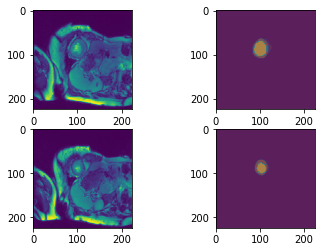

In [39]:


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(torch.squeeze(images_test[0]))

mask_squeeze_1 = torch.squeeze(masks_test[0])
axarr[0,1].imshow(mask_squeeze_1[0, :, :], alpha=0.5)
axarr[0,1].imshow(mask_squeeze_1[1, :, :], alpha=0.5)
axarr[0,1].imshow(mask_squeeze_1[2, :, :], alpha=0.5)
axarr[0,1].imshow(mask_squeeze_1[3, :, :], alpha=0.5)


axarr[1,0].imshow(torch.squeeze(images_test[1]))

mask_squeeze_2 = torch.squeeze(masks_test[1])
axarr[1,1].imshow(mask_squeeze_2[0, :, :], alpha=0.5)
axarr[1,1].imshow(mask_squeeze_2[1, :, :], alpha=0.5)
axarr[1,1].imshow(mask_squeeze_2[2, :, :], alpha=0.5)
axarr[1,1].imshow(mask_squeeze_2[3, :, :], alpha=0.5)
plt.show()

# plt.imshow(torch.squeeze(images_test_1))

In [41]:
pred_test = model(images_test)
print("Len:", len(pred_test))

final_pred = pred_test[2]
final_pred.shape

Len: 3


torch.Size([2, 4, 224, 224])

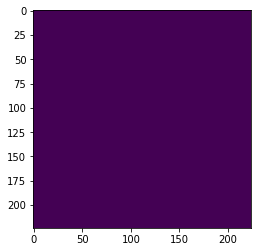

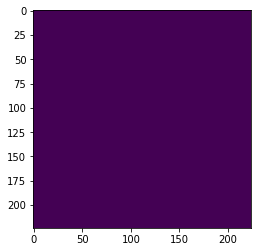

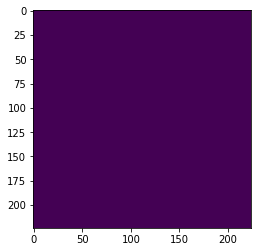

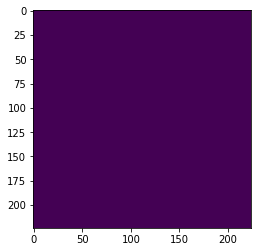

In [42]:
plt.imshow(final_pred[0][0,:,:].detach().numpy())
plt.show()
plt.imshow(final_pred[0][1,:,:].detach().numpy())
plt.show()
plt.imshow(final_pred[0][2,:,:].detach().numpy())
plt.show()
plt.imshow(final_pred[0][3,:,:].detach().numpy())
plt.show()

In [48]:
np.unique(final_pred[0][3].detach().numpy())

array([0.01240253], dtype=float32)

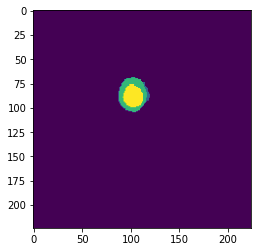

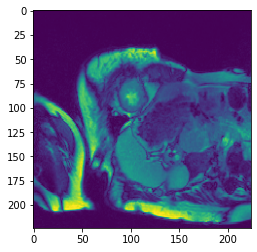

In [23]:
plt.imshow(np.argmax(masks_test_1[-1,:,:,:],0))
plt.show()
plt.imshow(images_test_1[-1,0,:,:])

In [30]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [24]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   38198 KB |   45723 KB |  122284 KB |   84085 KB |
|       from large pool |       0 KB |       0 KB |       0 KB |       0 KB |
|       from small pool |   38198 KB |   45723 KB |  122284 KB |   84085 KB |
|---------------------------------------------------------------------------|
| Active memory         |   38198 KB |   45723 KB |  122284 KB |   84085 KB |
|       from large pool |       0 KB |       0 KB |       0 KB |